In [9]:
%reload_ext autoreload
%autoreload 2

In [31]:
from gpt3forchem.data import get_uspto_yield_data
from gpt3forchem.api_wrappers import fine_tune, query_gpt3, extract_regression_prediction
from gpt3forchem.input import create_reaction_yield_prompts

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fastcore.xtras import save_pickle
import time

In [11]:
data = get_uspto_yield_data()

/Users/kevinmaikjablonka/git/kjappelbaum/gpt3forchem/gpt3forchem/data.py:226: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(datadir, "USTPO_yields.csv"))


In [12]:
train_reaction_smiles, test_reaction_smiles = train_test_split(data['reaction_smiles'].unique(), train_size=0.8)
train_data = data[data['reaction_smiles'].isin(train_reaction_smiles)].sample(80_000)
test_data = data[data['reaction_smiles'].isin(test_reaction_smiles)].sample(5_000)

In [13]:
train_prompts = create_reaction_yield_prompts(train_data) 
test_prompts = create_reaction_yield_prompts(test_data)

In [14]:
train_size  = len(train_prompts)
test_size = len(test_prompts)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = f"run_files/{filename_base}_train_prompts_uspto_yield_regression_{train_size}.jsonl"
valid_filename = f"run_files/{filename_base}_valid_prompts_uspto_yield_regression_{test_size}.jsonl"

train_prompts.to_json(train_filename, orient="records", lines=True)
test_prompts.to_json(valid_filename, orient="records", lines=True)


In [15]:
fine_tune(train_filename, valid_filename)

Uploaded file from run_files/2022-11-08-16-41-26_train_prompts_uspto_yield_regression_79996.jsonl: file-JpE4QZfKy6bc8sCpMKmEbpCm
Uploaded file from run_files/2022-11-08-16-41-26_valid_prompts_uspto_yield_regression_5000.jsonl: file-5zTJuM3JGKjj8C0gtVRIKMil
Created fine-tune: ft-tZzCs8f7geM3c7hrRyXLzD0h
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2022-11-08 16:43:16] Created fine-tune: ft-tZzCs8f7geM3c7hrRyXLzD0h
[2022-11-08 16:43:54] Fine-tune costs $26.95
[2022-11-08 16:43:55] Fine-tune enqueued. Queue number: 0

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-tZzCs8f7geM3c7hrRyXLzD0h

 
Upload progress:   0%|          | 0.00/93.2M [00:00<?, ?it/s]
Upload progress: 100%|██████████| 93.2M/93.2M [00:00<00:00, 68.3Git/s]

Upload progress:   0%|          | 0.00/5.84M [00:00<?, ?it/s]
Upload progress: 100%|██████████| 5.84M/5.84M [00:00<00:00, 9.65Git/s]



In [25]:
test_prompts_filtered = []

for i, row in test_prompts.iterrows():
    if len(row['prompt']) < 1000:
        test_prompts_filtered.append(row)

In [26]:
len(test_prompts_filtered)

4465

In [28]:
test_prompts_filtered_frame = pd.DataFrame(test_prompts_filtered)

In [29]:
completions = query_gpt3('ada:ft-lsmoepfl-2022-11-08-18-02-20', test_prompts_filtered_frame)

In [32]:
save_pickle('run_files/ada:ft-lsmoepfl-2022-11-08-18-02-20_completions.pkl', (completions, test_prompts_filtered_frame))

In [49]:
predictions = np.array([extract_regression_prediction(completions, i) for i, completion in enumerate(completions["choices"])])

In [36]:
true = test_prompts_filtered_frame['completion'].apply(lambda x: int(x.split('@@@')[0])).values

In [54]:
good_predictions = (predictions < 100) & (predictions > 0)
good_true = (true < 100) & (true > 0)

In [55]:
r2_score(true[good_predictions & good_true], predictions[good_predictions & good_true])

-0.034200796738945716

(0.0, 100.0)

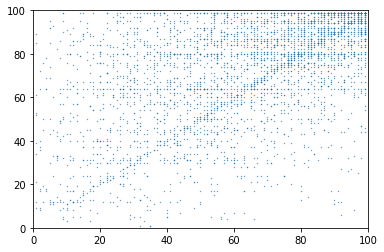

In [58]:
plt.scatter(true[good_predictions & good_true], predictions[good_predictions & good_true], s=.1)
plt.xlim(0, 100)
plt.ylim(0, 100)

In [59]:
errors = np.abs(true[good_predictions & good_true] - predictions[good_predictions & good_true])

In [64]:
small_errors = np.where(errors < 10)[0]

In [72]:
large_errors = np.where(errors > 10)[0]

(0.0, 100.0)

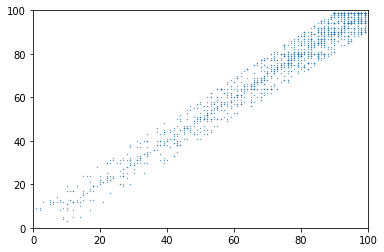

In [65]:
plt.scatter(true[good_predictions & good_true][small_errors], predictions[good_predictions & good_true][small_errors], s=.1)
plt.xlim(0, 100)
plt.ylim(0, 100)

In [67]:
len(small_errors) / len(true[good_predictions & good_true])

0.40210688591983557

Need to analyze what is different between the good and bad predictions.

In [70]:
test_prompts_filtered_frame.iloc[small_errors]['prompt'].values[0]

'What is the yield of the reaction with the following description: 1.0 g of Donepezil was dissolved in 9 ml of acetone under heating at 40° C. The solution was cooled to room temperature in an iced water bath. 0.31 g of Concentrated hydrochloric acid in 1 ml of acetone was added hereinto. It continued stirring over night at room temperature. Filtration of the separated crystals followed by drying. (water content: 0.03%)###'

In [71]:
test_prompts_filtered_frame.iloc[small_errors]['prompt'].values[1]

'What is the yield of the reaction with the following description: In 4 ml of tetrahydrofuran was suspended 0.11 g of sodium hydride (60% in oil), to which 0.5 ml of a solution containing 0.16 g of 2-butyn-1-ol in tetrahydrofuran was added dropwise at room temperature, followed by stirring for 10 minutes. To this was added dropwise 0.5 ml of a solution containing 0.56 g of 4-chloro-6-(3-bromo-2,2-dimethylpropyloxy)pyrimidine in tetrahydrofuran at 0° C., followed by stirring at the same temperature for 4 hours. The reaction mixture was then poured into a saturated aqueous ammonium chloride solution, which was extracted three times with t-butyl methyl ether. The combined organic layers were washed with a saturated aqueous sodium chloride solution, dried over anhydrous magnesium sulfate, and then concentrated. The residue was subjected to silica gel column chromatography.###'

In [78]:
test_prompts_filtered_frame.iloc[small_errors]['prompt'].values[2]

'What is the yield of the reaction with the following description: A solution of the product of Example 5E (69 mg, 0.15 mmol), 2-bromoacetamide (80 mg, 0.58 mmol), cesium carbonate (96 mg, 0.58 mmol), and tetrabutylammonium iodide (26 mg, 0.08 mmol) in N,N-dimethylformamide (2.4 mL) was stirred at 25° C. for 48 hours, diluted with ethyl acetate and treated with saturated ammonium chloride solution (2 mL). The organic layer was washed with water (3×) and saturated sodium chloride solution, dried (Na2SO4), filtered and concentrated in vacuo###'

In [79]:
test_prompts_filtered_frame.iloc[small_errors]['prompt'].values[3]

'What is the yield of the reaction with the following description: 0.23 g (0.00062 mol) of (S)-1-(5-propylaminomethyl-oxazol-2-yl)-11,11a-dihydro-8H,10H-azeto[1,2-a]imidazo[5,1-c]thieno[3,2-e][1,4]diazepin-8-one in 15 ml of ethanol was treated with 0.18 ml (0.00065 mol) of 3.7N ethanolic hydrochloric acid. The yellow solution was concentrated to 5 ml and treated with 15 ml of ethyl acetate. After stirring at 0° for 1/2 hr. the suspension was suction filtered. 218°-220° (dec.) and [α]D20 =-285.3° (H2O, c=3%).###'

In [73]:
test_prompts_filtered_frame.iloc[large_errors]['prompt'].values[0]

'What is the yield of the reaction with the following description: A mixture of 0.273 g 4-(2-ethyl-4,5,6,7-tetrahydro-(2H)-indazol-3-yl)-1-benzylpiperidine from Step B above, 0.789 g ammonium formate, and 35 mg 20% Pd(OH)2 in 6 mL methanol was heated at 65° C. for 1 h. Basic aqueous work-up with ether extraction.###'

In [74]:
test_prompts_filtered_frame.iloc[large_errors]['prompt'].values[1]

'What is the yield of the reaction with the following description: To a solution of N-(4-chlorobenzyl)-8-iodo-1-methyl-6-(4-morpholinylmethyl)-4-oxo-1,4-dihydro-3-quinolinecarboxamide (264 mg), PdCl2(PPh3)2 (17.3 mg), and CuI (4.7 mg) in 9.6 mL Et2NH is added propargyl alcohol (0.029 mL, 0.492 mmol). Distilled CH2Cl2 (14 mL) is added to help solublize the reactants. The reaction is stirred at room temperature overnight, then condensed to remove the solvents. The crude product is adsorbed onto silica and chromatographed (eluent 1% MeOH in CH2Cl2 (1L), 2% MeOH in CH2Cl2 (1L), and 3% MeOH in CH2Cl2 (2L)). Product-containing fractions are combined and condensed.###'

In [77]:
test_prompts_filtered_frame.iloc[large_errors]['prompt'].values[4]

'What is the yield of the reaction with the following description: In a microwaveable vessel, 0.65 g of 6-chloro-2-(4-methoxy-3,5-dimethylphenyl)oxazolo[4,5-c]pyridine were dissolved in 12 ml of absolute N,N-dimethylformamide, and 0.25 g of 2-fluorophenol, 0.88 g of cesium carbonate, 21 mg of copper (I) iodide and 40 mg of 1,10-phenanthroline were added. In a microwave reactor, the reaction was heated at 200° C. for 1 h. For work-up, the mixture was added to saturated aqueous sodium bicarbonate solution and extracted three times with ethyl acetate. The combined organic phases were washed with saturated aqueous sodium bisulaite solution, dried over sodium sulfate, filtered and concentrated. The crude product was purified by means of preparative HPLC,.###'

In [80]:
test_prompts_filtered_frame.iloc[large_errors]['prompt'].values[5]

'What is the yield of the reaction with the following description: To a stirred solution of the product from example 4, step (c) (10 g) in acetic acid (300 ml) at room temperature was added a solution of sodium nitrite (2.24 g) in water (30 ml). The reaction was stirred at 0° C. for 30 min, and , washing with water, to give the subtitled compound as a dark blue solid (4.8 g).###'

In [81]:
test_prompts_filtered_frame.iloc[large_errors]['prompt'].values[6]

'What is the yield of the reaction with the following description: The solution of 6-(4-fluorophenyl)-7-methyl-2,3-dihydro-1H-pyrrolizine (9.0 g, 42 mmol) in abs. THF (50 ml) is cooled to −15° C. N-Bromosuccinimide (3.46 g, 19.4 mmol) is added in portions; the mixture is stirred until no more starting material is detectable (TLC SiO2, diisopropyl ether-hexane 2:1). The black-purple-coloured reaction mixture is chromatographed on a column (20 cm×3 cm) packed with Al2O3 (ICI, for dry packing). The column is subsequently washed with n-hexane (80 ml), and the filtrates are concentrated. , which rapidly decomposes.###'

In [82]:
test_prompts_filtered_frame.iloc[large_errors]['prompt'].values[7]

'What is the yield of the reaction with the following description: 1-(2-Chlorophenyl)ethyl[3-(4-chloromethylphenyl)-4-isoxazolyl]carbamate (1.0 g, 2.56 mmol) obtained in Step B-6 of Example 1 was dissolved in N,N-dimethylformamide (30 ml), methyl 3-aminopropionate hydrochloride (1.07 g, 7.67 mmol) and potassium carbonate (2.12 g, 15.3 mmol) were added, and the mixture was stirred overnight at 50° C. 1N Hydrochloric acid was added at 0° C. to weak-acidify the reaction system, and the mixture was extracted 3 times with ethyl acetate. The organic layer was washed with saturated aqueous sodium hydrogencarbonate solution and saturated aqueous sodium chloride solution, and dried over anhydrous sodium sulfate. The solvent was evaporated under reduced pressure, and the residue was purified by column chromatography (methanol:dichloromethane=1:20).###'